In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2012.h5", 'r')

list(f.attrs)  # list attributes belonging to the root group

['Version']

In [2]:
f.attrs['Version']   # attributes can be used to provide desriptions of the content

'3.0.6'

In [3]:
list(f)  # list the datasets in the file

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_press_acha',
 'cloud_type',
 'coordinates',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [4]:
# Datasets are stored in a 2d array of time x location
dset = f['ghi']
dset.shape

(17568, 2018392)

In [5]:
print(dset[0:100, 5000])

[ 889  800  699  588  299  221  143   70   14    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   44  145  263  386  507  623  730  826  909  977 1028
 1062 1077 1074 1052 1012  955  879  791  692  582  465  344  223  110
   22    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   42  141  258  380  501
  618  726  822  906  975 1027 1060 1076 1074 1053 1014  957  887  800
  700  590]


In [6]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 00:30:00',
               '2012-01-01 01:00:00', '2012-01-01 01:30:00',
               '2012-01-01 02:00:00', '2012-01-01 02:30:00',
               '2012-01-01 03:00:00', '2012-01-01 03:30:00',
               '2012-01-01 04:00:00', '2012-01-01 04:30:00',
               ...
               '2012-12-31 19:00:00', '2012-12-31 19:30:00',
               '2012-12-31 20:00:00', '2012-12-31 20:30:00',
               '2012-12-31 21:00:00', '2012-12-31 21:30:00',
               '2012-12-31 22:00:00', '2012-12-31 22:30:00',
               '2012-12-31 23:00:00', '2012-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17568, freq=None)

In [7]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,b'None',b'None',b'None',b'None',-9999,210
1,-19.99,-175.220001,0.0,13,b'None',b'None',b'None',b'None',-9999,210
2,-19.99,-175.179993,0.0,13,b'None',b'None',b'None',b'None',-9999,210
3,-19.99,-175.139999,0.0,13,b'None',b'None',b'None',b'None',-9999,210
4,-19.99,-175.100006,0.0,13,b'None',b'None',b'None',b'None',-9999,210


In [8]:
# Datasets have been saved as integers
dset.dtype

dtype('int16')

In [9]:
dset.shape[0] * dset.shape[1] * 2 * 10**-9 # 70 GB per dataset!

70.918221312

In [10]:
dset.chunks # Chunked by week

(2688, 372)

In [11]:
dset.chunks[0] * dset.chunks[1] * 2 * 10**-6 # 2 MB per chunk

1.9998719999999999

In [12]:
# To convert dataset values back to floats use the 'psm_scale_factor'
dset.attrs['psm_scale_factor'] # Irradiance values have been truncated to integer precision

1

In [13]:
dset.attrs['psm_units']

'W/m2'

In [14]:
list(f['wind_speed'].attrs)

['psm_scale_factor']

In [15]:
# wind speed on the other hand has single decimal percision when scaled by 10
scale_factor = f['wind_speed'].attrs['psm_scale_factor']
units = dset.attrs['psm_units']
print('wind_speed scale factor = ', scale_factor)
print('wind_speed units after unscaling = ', units)
f['wind_speed'][0, 0] / scale_factor # divide by scale_factor to return native value

wind_speed scale factor =  10.0
wind_speed units after unscaling =  W/m2


3.9

In [16]:
#Time slicing
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 00:30:00',
               '2012-01-01 01:00:00', '2012-01-01 01:30:00',
               '2012-01-01 02:00:00', '2012-01-01 02:30:00',
               '2012-01-01 03:00:00', '2012-01-01 03:30:00',
               '2012-01-01 04:00:00', '2012-01-01 04:30:00',
               ...
               '2012-12-31 19:00:00', '2012-12-31 19:30:00',
               '2012-12-31 20:00:00', '2012-12-31 20:30:00',
               '2012-12-31 21:00:00', '2012-12-31 21:30:00',
               '2012-12-31 22:00:00', '2012-12-31 22:30:00',
               '2012-12-31 23:00:00', '2012-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17568, freq=None)

In [17]:
march = time_index.month == 3
np.where(march)[0]

array([2880, 2881, 2882, ..., 4365, 4366, 4367], dtype=int64)

In [18]:
timestep = np.where(time_index == '2012-07-04 00:00:00')[0][0]
timestep

8880

In [19]:
# Extract coordinates (lat, lon)
print(dict(f['coordinates'].attrs))
coords = f['coordinates'][...]

{'description': '(latitude, longitude)'}


In [20]:
%time data = dset[timestep, ::1000]
data

Wall time: 26.1 s


array([145, 511, 484, ...,   0,   0,   0], dtype=int16)

In [37]:
dset = f['ghi']
%time data = dset[timestep, ::1000]   # extract every 1000th location at a particular time
df = pd.DataFrame() # Combine data with coordinates in a DataFrame
df['longitude'] = coords[::1000, 1]
df['latitude'] = coords[::1000, 0]
df['ghi'] = data / dset.attrs['psm_scale_factor'] # unscale dataset
print(data)

Wall time: 26.1 s
[145 511 484 ...   0   0   0]


In [22]:
df.shape

(2019, 3)

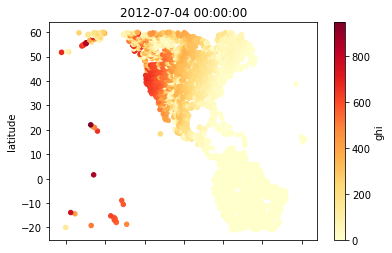

In [23]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [24]:
# Full resolution subset of California
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
70276,32.529999,-117.099998,55.062500,-8,b'United States',b'California',b'San Diego',b'None',32326,130
70588,32.570000,-117.099998,7.100000,-8,b'United States',b'California',b'San Diego',b'Tijuana',27971,190
70589,32.570000,-117.059998,24.920000,-8,b'United States',b'California',b'San Diego',b'Tijuana',51608,190
70590,32.570000,-117.019997,96.599998,-8,b'United States',b'California',b'San Diego',b'Tijuana',15236,110
70591,32.570000,-116.980003,140.600006,-8,b'United States',b'California',b'San Diego',b'Tijuana',2949,130


In [34]:
CA.shape
print(CA.index)
ind = CA.index[1]
print(ind)
mylist = CA.index

Int64Index([ 70276,  70588,  70589,  70590,  70591,  70592,  70593,  70594,
             70595,  70596,
            ...
            172682, 172683, 172684, 172685, 172686, 172687, 172688, 172689,
            172690, 172691],
           dtype='int64', length=26010)
70588


In [66]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2012.h5", 'r')

list(f.attrs)  # list attributes belonging to the root group    print(f"Item value: {item}")

dset = f['ghi']
print(type(f['ghi']))



<class 'h5pyd._hl.dataset.Dataset'>


In [62]:
import pandas as pd

data = []
%time 
for value in CA.index:
    print(CA.index[value])
    data.append(dset[timestep][CA.index[value]])  # full-resolution subset

df = CA[['longitude', 'latitude']].copy()
df['ghi'] = data / dset.attrs['psm_scale_factor']
df.shape

Wall time: 0 ns


IndexError: index 70276 is out of bounds for axis 0 with size 26010

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ghi

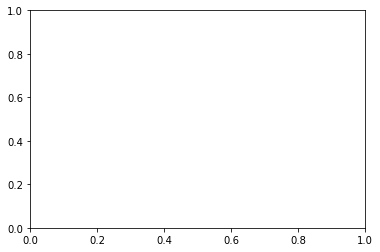

In [60]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [ ]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

dset_coords = f['coordinates'][...]
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

In [ ]:
NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1] )

In [ ]:
print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(dset_coords[NewYorkCity_idx]))

In [ ]:
# Get the entire 2012 timeseries data for a point in NYC
%time tseries = dset[:, NewYorkCity_idx] / dset.attrs['psm_scale_factor']

In [ ]:
len(tseries)   # 1 years * 365 days * 24 hours * 30 minutes

In [ ]:
plt.plot(time_index, tseries)
plt.ylabel("ghi")
plt.title("NYC ghi in 2012")

In [ ]:
# GHI Statistics
df = pd.DataFrame({'ghi': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

In [ ]:
agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="ghi")
agg

In [ ]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean GHI (W/m^2)")
plt.colorbar()